## CIFAR Using CNN 

#### Ahmad Pouramini, Benyamin Hosseini 

---



This is the implementatin of CIFAR using CNN.



## Loading Data

Using TensorFlow backend.


Found GPU at:/device:GPU:0


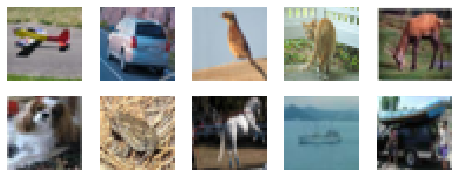

In [1]:
# Import all modules
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

# GPU Processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:{}'.format(device_name))

batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
 
num_classes = 10 #
epochs = 100 # repeat 100 times

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
# x_train - training data(images), y_train - labels(digits)

# Print figure with 10 random images from each
 
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
#   ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


## Data Normalization

In [0]:
# Convert and pre-processing

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_valid = x_valid.astype('float32')
x_train  /= 255
x_test /= 255
x_valid /= 255


## Creating the base model

In [0]:
def base_model(drop_out = False):  # 3 Convolutional layers + 1 hidden layer MLP
    model = Sequential()
   
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))  # first layer filters: 32 filters 3x3
    if drop_out:
        model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu'))  # second layer filters: 32 filters 3x3
    model.add(MaxPooling2D(pool_size=(2, 2)))  # second layer pooling: max pooling 2x2

    model.add(Conv2D(64, (3, 3), activation='relu'))  # third layer filters: 64 filters 3x3
    model.add(MaxPooling2D(pool_size=(2, 2)))  # third layer pooling: max pooling 2x2

    # MLP
    model.add(Flatten())
    if drop_out:
        model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu',kernel_constraint=maxnorm(3)))  # MLP first hidden layer neurons
    if drop_out:
        model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # MLP output layer neurons
    
    epochs = 25 
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, decay=decay, momentum=0.9, nesterov=False)  # sigmoid optimizer

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
  
def base_model_new(drop_out=False):
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same',  input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same' ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  if drop_out:
    model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same' ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same' ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  if drop_out:
    model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same' ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same' ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  if drop_out:
    model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  
  
  lrate = 0.01
  decay = lrate/epochs
  sgd = SGD(lr=lrate, decay=decay, momentum=0.9, nesterov=False)  # sigmoid optimizer

  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  return model
 

## Model Training

In [4]:
from keras.preprocessing.image import ImageDataGenerator

epochs = 10

data_augmentation = True

cnn_dropout = base_model(drop_out=True)
cnn_normal = base_model()


print('Not using data augmentation without dropout.')
hist_normal = cnn_normal.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

print('Not using data augmentation with dropout.')
hist_dropout = cnn_dropout.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

scores = cnn_normal.evaluate(x_test,y_test,verbose=0)
print("Accuracy (without dropout/without data augmentation): %.2f%%" % (scores[1]*100))

scores = cnn_dropout.evaluate(x_test,y_test,verbose=0)
print("Accuracy (with dropout/without data augmentation): %.2f%%" % (scores[1]*100))


print("Data Augmentation:", data_augmentation)


if data_augmentation:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


    datagen.fit(x_train)
  
    
    
    steps = len(x_train)/ batch_size
    print("Steps:", steps)
    print('Using data augmentation.')
    hist_normal_data_aug =cnn_normal.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4, steps_per_epoch = steps)
    
    print('Using data augmentation and drop out')
    hist_dropout_data_aug =cnn_dropout.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4, steps_per_epoch = steps)
    

    scores = cnn_normal.evaluate(x_test,y_test,verbose=0)
    print("Accuracy (without dropout/with data augmentation): %.2f%%" % (scores[1]*100))

    scores = cnn_dropout.evaluate(x_test,y_test,verbose=0)
    print("Accuracy (with dropout/with data augmentation): %.2f%%" % (scores[1]*100))
    






Not using data augmentation without dropout.
Train on 45000 samples, validate on 10000 samples
Epoch 1/10
45000/45000 [==============================] - 20s 441us/step - loss: 1.6262 - acc: 0.4124 - val_loss: 1.3168 - val_acc: 0.5247
Epoch 2/10
45000/45000 [==============================] - 19s 413us/step - loss: 1.1387 - acc: 0.5968 - val_loss: 1.0808 - val_acc: 0.6220
Epoch 3/10
45000/45000 [==============================] - 19s 416us/step - loss: 0.9138 - acc: 0.6799 - val_loss: 0.9856 - val_acc: 0.6621
Epoch 4/10
45000/45000 [==============================] - 19s 415us/step - loss: 0.7405 - acc: 0.7413 - val_loss: 0.9184 - val_acc: 0.6921
Epoch 5/10
45000/45000 [==============================] - 18s 408us/step - loss: 0.5851 - acc: 0.7964 - val_loss: 0.8903 - val_acc: 0.6988
Epoch 6/10
45000/45000 [==============================] - 19s 412us/step - loss: 0.4380 - acc: 0.8480 - val_loss: 0.9686 - val_acc: 0.6983
Epoch 7/10
45000/45000 [==============================] - 19s 416us/ste

## Results

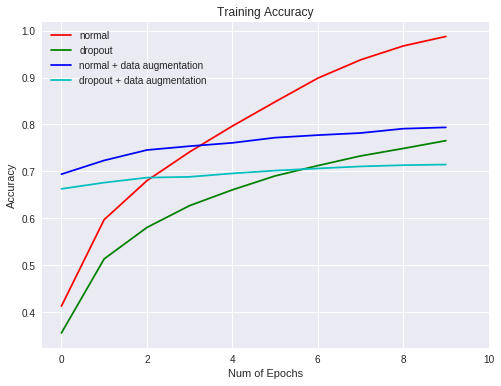

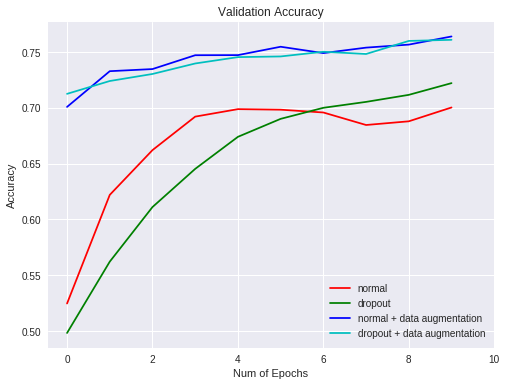

In [7]:
plt.figure(0)
plt.plot(hist_normal.history['acc'],'r')
plt.plot(hist_dropout.history['acc'],'g')
plt.plot(hist_normal_data_aug.history['acc'],'b')
plt.plot(hist_dropout_data_aug.history['acc'],'c')

plt.xticks(np.arange(0, epochs +1, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend(['normal','dropout',
            'normal + data augmentation', 
            'dropout + data augmentation'])
 
plt.figure(1)
plt.plot(hist_normal.history['val_acc'],'r')
plt.plot(hist_dropout.history['val_acc'],'g')
plt.plot(hist_normal_data_aug.history['val_acc'],'b')
plt.plot(hist_dropout_data_aug.history['val_acc'],'c')

plt.xticks(np.arange(0, epochs +1, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(['normal','dropout',
            'normal + data augmentation', 
            'dropout + data augmentation'])
 
plt.show()

scores = cnn_normal.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_normal.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
import itertools

plot_confusion_matrix(cm, range(10), True)